In [1]:
from __future__ import print_function
import os
#os.environ['CUDA_VISIBLE_DEVICES']='0'
import numpy as np
import cv2
import keras
import tensorflow
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
%matplotlib inline 
import pandas as pd
import math
import imutils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import glob
from tqdm import tqdm
import random

from sklearn import preprocessing
import PIL.Image as Image
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
from skimage import io
#from shutil import copyfile
import time

Using TensorFlow backend.


In [2]:
#Faster R-CNN, RetinaNet, YOLOv3, SSD

In [41]:
filepath='/home/Documents/code/Tutorials/'
path_data=filepath+'datasets/OpenImagesDatasetV6/'
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [42]:
images_boxable = pd.read_csv(path_data+images_boxable_fname)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [43]:
annotations_bbox = pd.read_csv(path_data+annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

In [44]:
class_descriptions = pd.read_csv(path_data+class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [45]:
'''
Plot Bounding box
'''
def plot_bbox(img_id):
    img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
    img = io.imread(img_url)
    height, width, channel = img.shape
    print(f"Image: {img.shape}")
    bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in bboxs.iterrows():
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        xmin = int(xmin*width)
        xmax = int(xmax*width)
        ymin = int(ymin*height)
        ymax = int(ymax*height)
        label_name = row['LabelName']
        class_series = class_descriptions[class_descriptions[0]==label_name]
        class_name = class_series[1].values[0]
        print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
    plt.figure(figsize=(15,10))
    plt.title('Image with Bounding Box')
    plt.imshow(img)
    plt.axis("off")
    plt.show()



In [46]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (1200, 1500, 3)
Coordinates: (214, 302), (1114, 860)


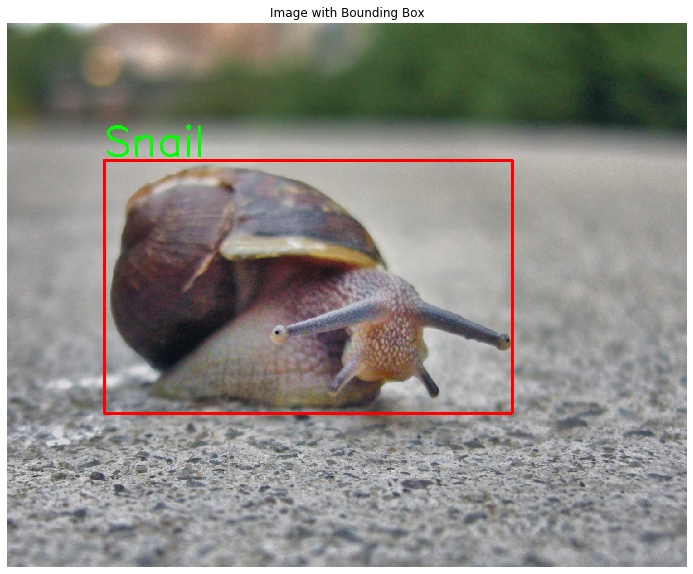

Image: (1536, 2048, 3)
Coordinates: (800, 0), (1638, 348)


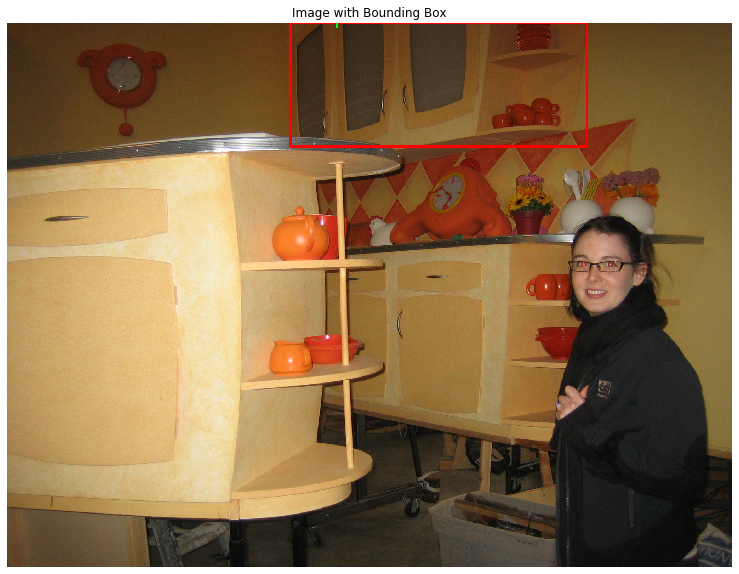

Image: (2592, 3456, 3)
Coordinates: (725, 0), (3451, 2589)


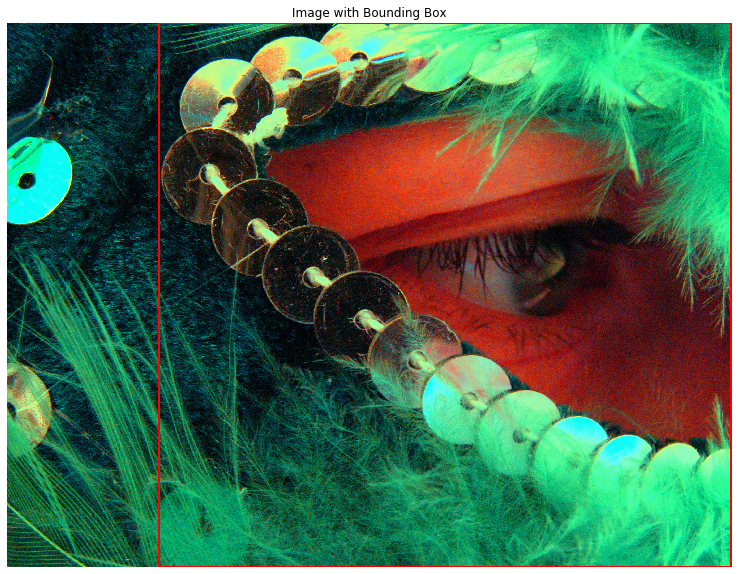

Image: (3592, 2694, 3)
Coordinates: (538, 457), (2078, 3589)


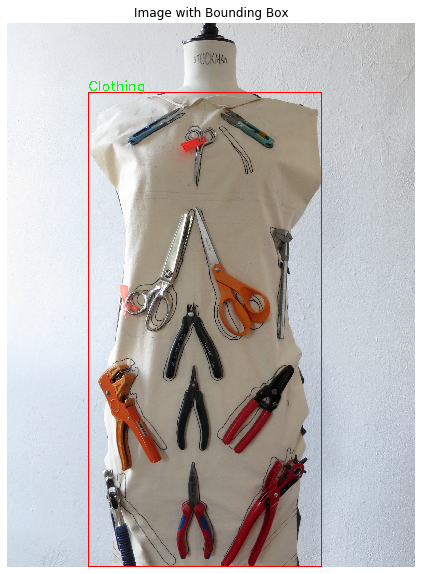

Image: (2848, 4288, 3)
Coordinates: (972, 56), (2588, 1882)


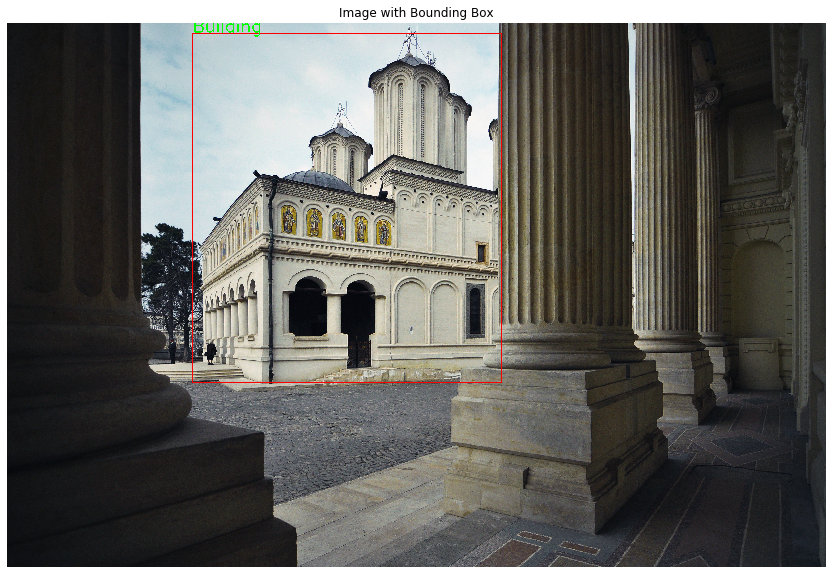

In [47]:
for img_id in random.sample(list(least_objects_img_ids), 5):
    plot_bbox(img_id)

In [48]:
class_descriptions.loc[class_descriptions[1].isin(['Person', 'Mobile phone', 'Car'])]

0             1
68   /m/01g317        Person
312   /m/050k8  Mobile phone
570    /m/0k4j           Car

In [49]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
person_pd = class_descriptions[class_descriptions[1]=='Person']
phone_pd = class_descriptions[class_descriptions[1]=='Mobile phone']
car_pd = class_descriptions[class_descriptions[1]=='Car']

label_name_person = person_pd[0].values[0]
label_name_phone = phone_pd[0].values[0]
label_name_car = car_pd[0].values[0]

Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image

In [50]:
person_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_person]
phone_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_phone]
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]

In [51]:
print('There are %d persons in the dataset' %(len(person_bbox)))
print('There are %d phones in the dataset' %(len(phone_bbox)))
print('There are %d cars in the dataset' %(len(car_bbox)))
person_img_id = person_bbox['ImageID']
phone_img_id = phone_bbox['ImageID']
car_img_id = car_bbox['ImageID']

There are 1034721 persons in the dataset
There are 6365 phones in the dataset
There are 248075 cars in the dataset


In [52]:
person_img_id = np.unique(person_img_id)
phone_img_id = np.unique(phone_img_id)
car_img_id = np.unique(car_img_id)
print('There are %d images which contain persons' % (len(person_img_id)))
print('There are %d images which contain phones' % (len(phone_img_id)))
print('There are %d images which contain cars' % (len(car_img_id)))

There are 248384 images which contain persons
There are 4312 images which contain phones
There are 89465 images which contain cars


In [53]:
#We just randomly pick 1000 images in here.
# here I've chosen only 10 images for speed, change it to your liking
n = 10
subperson_img_id = random.sample(list(person_img_id), n)
subphone_img_id = random.sample(list(phone_img_id), n)
subcar_img_id = random.sample(list(car_img_id), n)

In [54]:
subperson_pd = images_boxable.loc[images_boxable['ImageID'].isin(subperson_img_id)]
subphone_pd = images_boxable.loc[images_boxable['ImageID'].isin(subphone_img_id)]
subcar_pd = images_boxable.loc[images_boxable['ImageID'].isin(subcar_img_id)]

In [55]:
subperson_pd.shape

(10, 12)

In [56]:
subperson_pd.head()

ImageID Subset  \
35734   b9f7e76cd3a216d1  train   
308535  cceea48db6f37a07  train   
365770  73b1d95f10f99172  train   
383723  77202a710ebbdb47  train   
537998  c0c983ffe4eaf956  train   

                                              OriginalURL  \
35734   https://farm2.staticflickr.com/8197/8162300486...   
308535  https://farm8.staticflickr.com/2917/1397506555...   
365770  https://farm3.staticflickr.com/2022/2119251378...   
383723  https://farm8.staticflickr.com/5528/9395811770...   
537998  https://farm7.staticflickr.com/8113/8671207466...   

                                       OriginalLandingURL  \
35734   https://www.flickr.com/photos/usnavalwarcolleg...   
308535  https://www.flickr.com/photos/chrisdag/1397506...   
365770  https://www.flickr.com/photos/charlietphoto/21...   
383723       https://www.flickr.com/photos/moe/9395811770   
537998  https://www.flickr.com/photos/gotovan/8671207466/   

                                             License  \
35734   https://creativecommons.org/licenses/by/2.0/   
308535  https://creativecommons.org/licenses/by/2.0/   
365770  https://creativecommons.org/licenses/by/2.0/   
383723  https://creativecommons.org/licenses/by/2.0/   
537998  https://creativecommons.org/licenses/by/2.0/   

                                         AuthorProfileURL  \
35734   https://www.flickr.com/people/usnavalwarcolleg...   
308535            https://www.flickr.com/people/chrisdag/   
365770       https://www.flickr.com/people/charlietphoto/   
383723                 https://www.flickr.com/people/moe/   
537998             https://www.flickr.com/people/gotovan/   

                        Author                   Title  OriginalSize  \
35734   U.S. Naval War College                _0013339       1367506   
308535                ChrisDag                DSC_0024       1616928   
365770        Charles Thompson                   Henry       4021239   
383723           Stephan Mosel           Chick Magnet.         79287   
537998                 GoToVan  2013 Vancouver Sun Run       4568568   

                     OriginalMD5  \
35734   wIrCR8qpMyaNKkue24nI5Q==   
308535  mXE8jOcrz7A3Pky2GajEdg==   
365770  7steiSS9ZmEWSe6wDlXqLw==   
383723  RGGdPn49CGUB2xyK5IGJgA==   
537998  wqNfBqwkA2YFkMFkk79cZw==   

                                         Thumbnail300KURL  Rotation  
35734   https://c8.staticflickr.com/9/8197/8162300486_...       0.0  
308535  https://c6.staticflickr.com/3/2917/13975065550...       0.0  
365770  https://c1.staticflickr.com/3/2022/2119251378_...       0.0  
383723  https://c3.staticflickr.com/6/5528/9395811770_...       0.0  
537998  https://c1.staticflickr.com/9/8113/8671207466_...       0.0

In [57]:
subperson_dict = subperson_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subphone_dict = subphone_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subcar_dict = subcar_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [58]:
mappings = [subperson_dict, subphone_dict, subcar_dict]

In [59]:
len(mappings)

3

In [60]:
len(mappings[0])

10

In [61]:
classes = ['Person', 'Mobile phone', 'Car']

In [24]:
# download images
for idx, obj_type in enumerate(classes):
    n_issues = 0
    # create the directory
    if not os.path.exists(path_data+obj_type):
        os.mkdir(obj_type)
    for img_id, url in mappings[idx].items():
        try:
            img = io.imread(url)
            saved_path = os.path.join(obj_type, img_id+".jpg")
            io.imsave(saved_path, img)
        except Exception as e:
             n_issues += 1
    print(f"Images Issues: {n_issues}")

Images Issues: 1
Images Issues: 0
Images Issues: 1


In [32]:
!ls /home/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/Person | wc -l

9


In [33]:
!ls /home/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/Mobile\ phone | wc -l

10


In [34]:
!ls /home/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/Car | wc -l

9


In [66]:
# save images to train and test directory
train_path = path_data+'train/'
test_path =path_data+'test/'

In [67]:
#mkdir path_data+'train' path_data+'test'

In [73]:
random.seed(1)
from shutil import copyfile

In [74]:
for i in range(len(classes)):
    all_imgs = os.listdir(path_data+classes[i])
    print('all_imgs:', all_imgs)
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    path_='/home/Documents/code/Tutorials/datasets/OpenImagesDatasetV6'
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(path_,classes[i], train_imgs[j])
        print('original_path:', original_path)
        #new_path = os.path.join(train_path, train_imgs[j])
        new_path = train_path+ train_imgs[j]
        print('new_path:', new_path)
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(path_,classes[i], test_imgs[j])
        #new_path = os.path.join(test_path, test_imgs[j])
        new_path = test_path +test_imgs[j]
        copyfile(original_path, new_path)

all_imgs: ['c4247e7115a7ed3c.jpg', '4a422d8e71aa40c1.jpg', 'f7a7fac116823267.jpg', 'eb8aecdcaf09dc9d.jpg', 'bda594f133165e4a.jpg', 'd2a674963d99106b.jpg', 'a68a71763d34b0c2.jpg', '3192e60d58e8bb43.jpg', '67e71157a757096a.jpg']
original_path: /home/an84020/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/Person/d2a674963d99106b.jpg
new_path: /home/an84020/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/train/d2a674963d99106b.jpg
original_path: /home/an84020/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/Person/a68a71763d34b0c2.jpg
new_path: /home/an84020/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/train/a68a71763d34b0c2.jpg
original_path: /home/an84020/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/Person/3192e60d58e8bb43.jpg
new_path: /home/an84020/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/train/3192e60d58e8bb43.jpg
original_path: /home/an84020/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/Person/bda594f133165e4a.jpg
new_path: /hom

In [75]:
!ls /home/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/train | wc -l

24


In [76]:
!ls /home/Documents/code/Tutorials/datasets/OpenImagesDatasetV6/test | wc -l

4


In [78]:
import sys

label_names = [label_name_person, label_name_phone, label_name_car]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)



In [79]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  c4247e7115a7ed3c.jpg  0.080556  0.823611  0.020833  0.998611    Person
1  32f0cb8aed2247d2.jpg  0.000000  0.533125  0.201238  0.668731       Car
2  32f0cb8aed2247d2.jpg  0.004375  0.251875  0.208204  0.325077       Car
3  32f0cb8aed2247d2.jpg  0.054375  0.983125  0.177245  0.979102       Car
4  32f0cb8aed2247d2.jpg  0.735625  0.868750  0.147059  0.243034       Car

In [80]:


train_df.shape



(66, 6)

In [81]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (720, 720, 3)
Coordinates: (58, 14), (592, 718)
Coordinates: (288, 122), (659, 679)


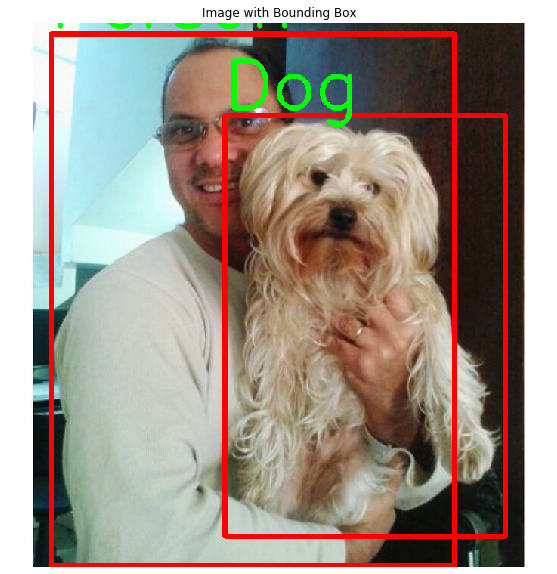

Image: (2836, 3512, 3)
Coordinates: (2333, 1734), (2805, 2598)
Coordinates: (63, 1378), (458, 1889)
Coordinates: (1628, 921), (1909, 1022)
Coordinates: (3162, 1121), (3334, 1545)
Coordinates: (3353, 566), (3406, 651)
Coordinates: (0, 570), (1872, 1896)
Coordinates: (15, 590), (884, 921)
Coordinates: (190, 502), (3452, 2776)
Coordinates: (2583, 417), (3051, 689)
Coordinates: (2662, 408), (3070, 482)
Coordinates: (3090, 370), (3505, 667)


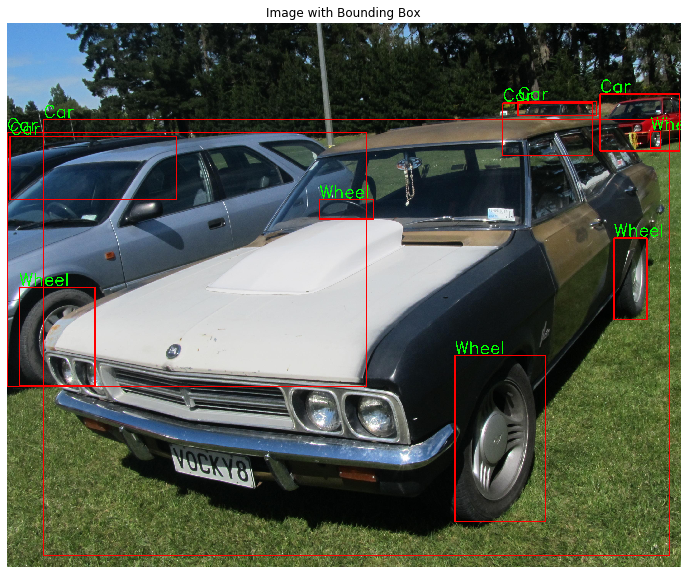

In [82]:
for img_id in train_img_ids:
    plot_bbox(img_id)

In [84]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(val_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [85]:
val_df.head()

FileName      XMin      XMax      YMin      YMax     ClassName
0  f7a7fac116823267.jpg  0.291875  0.701250  0.212946  0.962477        Person
1  3acad60b0ff50f88.jpg  0.000000  0.244375  0.222222  0.481111           Car
2  3acad60b0ff50f88.jpg  0.067500  0.869375  0.155556  0.871111           Car
3  a0b677e1c3a84996.jpg  0.211382  0.847561  0.084926  0.857749  Mobile phone
4  d47b7200efdd0c82.jpg  0.308581  0.589109  0.014851  0.898515  Mobile phone

In [ ]:
test_img_ids = val_df["FileName"].head().str.split(".").str[0].unique()

In [86]:
for img_id in test_img_ids:
    plot_bbox(img_id)

NameError: name 'test_img_ids' is not defined